In [29]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE

In [30]:
df = pd.read_csv("../Dataframes/reduced_merge1_corr.csv")

In [31]:
df.head(2)

,cancer,ENSG00000000003,ENSG00000002726,ENSG00000004846,ENSG00000005001,ENSG00000005421,ENSG00000006210,ENSG00000006659,ENSG00000006747,ENSG00000007062,...,ENSG00000225857,ENSG00000225986,ENSG00000226454,ENSG00000226478,ENSG00000227028,ENSG00000227359,ENSG00000230071,Unnamed: 0,mutational_subclass,cancer_type
0,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3-Breast-Her2-ampl,HER2+,Breast
1,1,0.0,0.0,2.302585,0.0,0.0,0.0,0.0,0.0,0.0,...,1.791759,0.0,0.0,0.0,0.0,0.0,0.0,8-Breast-WT,wt,Breast


In [32]:

# Define columns to drop (non-feature columns)
columns_to_drop = ['Unnamed: 0', 'cancer', 'cancer_type', 'mutational_subclass']

# Features = all columns except non-feature columns
X = df.drop(columns = columns_to_drop)
y = df["cancer"]

# Remove constant features
var_filter = VarianceThreshold(threshold=0.0)
X = var_filter.fit_transform(X)
print(f"Removed {len(var_filter.get_support()) - sum(var_filter.get_support())} constant features.")

# Verify all features are numeric
non_numeric_cols = pd.DataFrame(X).select_dtypes(include=['object', 'category']).columns
if len(non_numeric_cols) > 0:
    raise ValueError(f"Non-numeric feature columns detected: {non_numeric_cols}. Please encode or drop them.")


# Stratified split (preserves class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify = y
)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42, k_neighbors=1)  # Reduced k_neighbors for small classes
X_train, y_train = smote.fit_resample(X_train, y_train)
print(f"After SMOTE, training set size: {X_train.shape}")

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Feature selection (pick top 200 features to balance informativeness and noise)
k = min(200, X.shape[1])
selector = SelectKBest(f_classif, k=k)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

# Define classifiers with class weights
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42, class_weight='balanced'),
    "SVM": SVC(kernel='linear', random_state=42, class_weight='balanced')
}

# Train, evaluate, and collect F1-scores
f1_scores = {}
for name, clf in classifiers.items():
    print(f"\n### Evaluating {name} ###")
    
    # Train classifier
    clf.fit(X_train, y_train)
    
    # Predictions
    y_pred = clf.predict(X_test)
    
    # Evaluation
    print(f"Classification Report for {name}:\n",classification_report(y_test, y_pred,zero_division=0))
    print(f"Confusion Matrix for {name}:\n", 
          confusion_matrix(y_test, y_pred))
    
    # Store weighted F1-score
    f1_scores[name] = f1_score(y_test, y_pred, average='weighted')

# Print F1-scores for comparison
print("\nWeighted F1-Scores:")
for name, score in f1_scores.items():
    print(f"{name}: {score:.4f}")

Removed 0 constant features.
After SMOTE, training set size: (442, 117)

### Evaluating Random Forest ###


c:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.96      1.00      0.98        55

    accuracy                           0.96        57
   macro avg       0.48      0.50      0.49        57
weighted avg       0.93      0.96      0.95        57

Confusion Matrix for Random Forest:
 [[ 0  2]
 [ 0 55]]

### Evaluating KNN ###
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.98      0.96      0.97        55

    accuracy                           0.95        57
   macro avg       0.66      0.73      0.69        57
weighted avg       0.96      0.95      0.95        57

Confusion Matrix for KNN:
 [[ 1  1]
 [ 2 53]]

### Evaluating Logistic Regression ###
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

   

c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(



### Evaluating Random Forest ###
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.96      1.00      0.98        55

    accuracy                           0.96        57
   macro avg       0.48      0.50      0.49        57
weighted avg       0.93      0.96      0.95        57

Confusion Matrix for Random Forest:
 [[ 0  2]
 [ 0 55]]

### Evaluating KNN ###
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.98      0.96      0.97        55

    accuracy                           0.95        57
   macro avg       0.66      0.73      0.69        57
weighted avg       0.96      0.95      0.95        57

Confusion Matrix for KNN:
 [[ 1  1]
 [ 2 53]]

### Evaluating Logistic Regression ###
Classification Report for Logistic Regression:
               precision 

c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


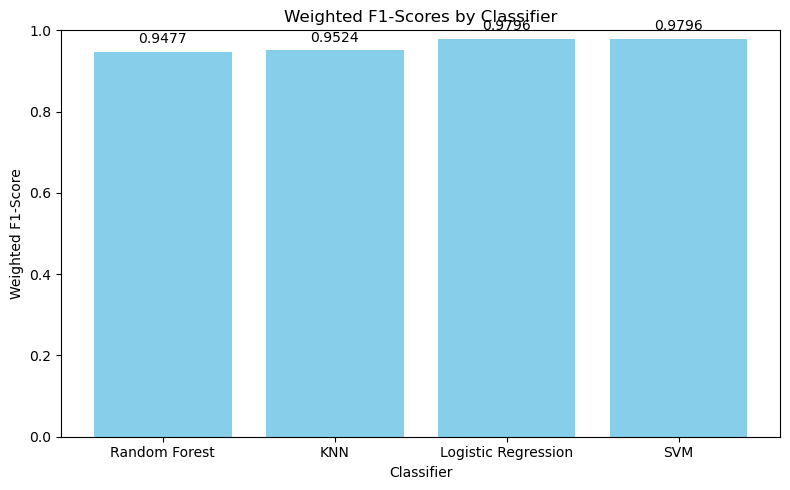

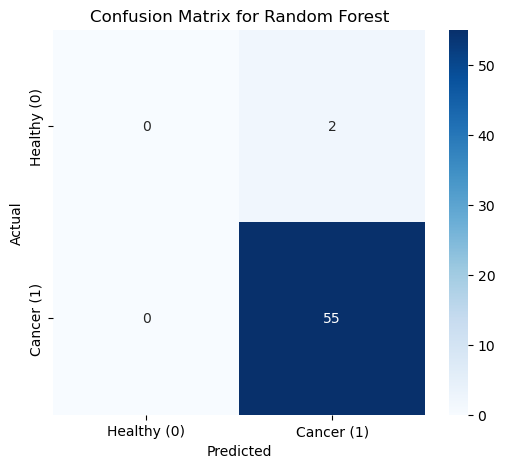

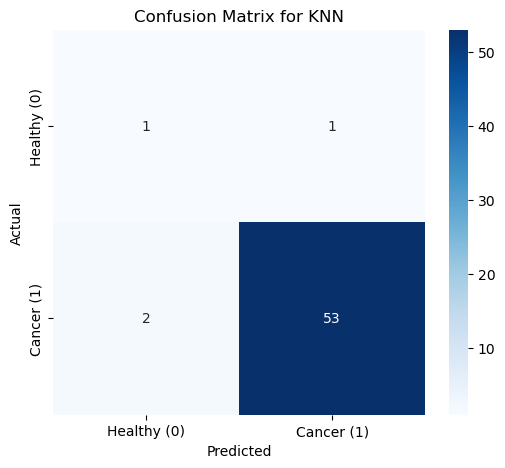

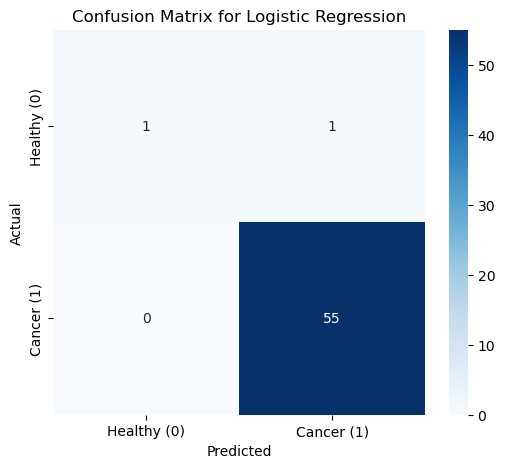

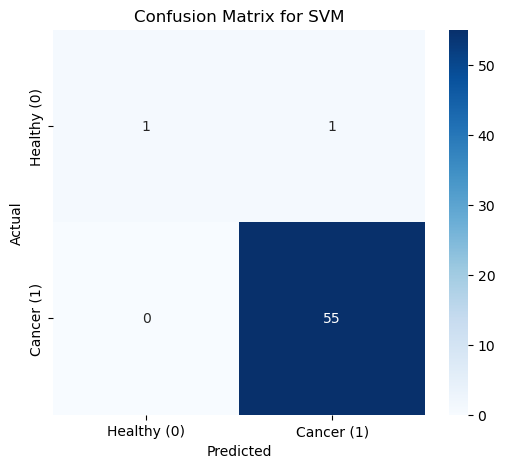

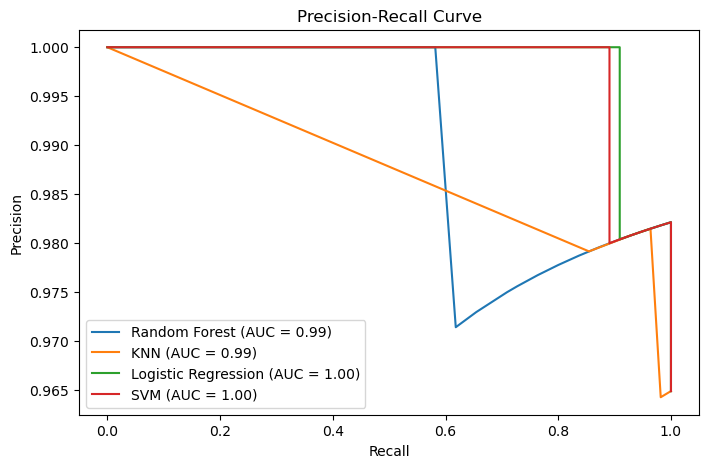

Visualizations saved in '../Dataframes/' directory.


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc

f1_scores = {}
cm_dict = {}  # Initialize here
for name, clf in classifiers.items():
    print(f"\n### Evaluating {name} ###")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred, zero_division=0))
    print(f"Confusion Matrix for {name}:\n", confusion_matrix(y_test, y_pred))
    f1_scores[name] = f1_score(y_test, y_pred, average='weighted')
    cm_dict[name] = confusion_matrix(y_test, y_pred)


# 1. Bar Plot of Weighted F1-Scores
plt.figure(figsize=(8, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
plt.title('Weighted F1-Scores by Classifier')
plt.xlabel('Classifier')
plt.ylabel('Weighted F1-Score')
plt.ylim(0, 1)
for i, v in enumerate(f1_scores.values()):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.savefig('../Dataframes/f1_scores_bar.png')
plt.show()

# 2. Confusion Matrix Heatmaps
for name, cm in cm_dict.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy (0)', 'Cancer (1)'], yticklabels=['Healthy (0)', 'Cancer (1)'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'../Dataframes/cm_{name.lower().replace(" ", "_")}.png')
    plt.show()

# 3. Precision-Recall Curve (with fallback for SVM)
plt.figure(figsize=(8, 5))
for name, clf in classifiers.items():
    if hasattr(clf, 'predict_proba'):  # Check if predict_proba is available
        y_prob = clf.predict_proba(X_test)[:, 1]  # Use probabilities for classifiers that support it
    else:  # Fallback for SVM (uses decision_function scaled to [0, 1])
        decision_values = clf.decision_function(X_test)
        y_prob = (decision_values - decision_values.min()) / (decision_values.max() - decision_values.min())  # Normalize to [0, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('../Dataframes/pr_curve.png')
plt.show()

print("Visualizations saved in '../Dataframes/' directory.")